In [1]:
import ogr
import gdal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
daShapefile = "SDM320384/ll_gda94/shape/user_polygon/CATCHMENTS/LANDUSE_2014.shp"

driver = ogr.GetDriverByName('ESRI Shapefile')

dataSource = driver.Open(daShapefile, 0) # 0 means read-only. 1 means writeable.

# Check to see if shapefile is found.
if dataSource is None:
    print('Could not open %s' % (daShapefile))
else:
    print('Opened %s' % (daShapefile))
    layer = dataSource.GetLayer()
    featureCount = layer.GetFeatureCount()
    print("Number of features: %d" % (featureCount))

Opened SDM320384/ll_gda94/shape/user_polygon/CATCHMENTS/LANDUSE_2014.shp
Number of features: 148852


In [3]:
temp_feature = layer[2]

In [4]:
temp_feature.items()

{'CMA': 'WIMMERA',
 'HECTARES': 14.08566905,
 'IRR_STATUS': None,
 'LC_CODE_14': '21',
 'LC_CODE_15': '21',
 'LC_DESC_14': 'Pasture and grassland',
 'LC_DESC_15': 'Pasture and grassland',
 'LGA': 'NORTHERN GRAMPIANS',
 'LU_1': '6',
 'LU_2': '60',
 'LU_3': '601',
 'LU_CODE': '601',
 'LU_DESC': 'Unspecified - Transport, Storage, Utilities and Communication',
 'PARCEL_PFI': '52511043',
 'PARCEL_SPI': '8D~6\\PP2419',
 'PC_LGAC': '357',
 'PROP_PFI': '52511043',
 'PR_PROPNUM': None,
 'TENURE': 'PUBLIC'}

In [5]:
# select shapes in the area of interest
area_filter = "POLYGON ((143.32317350376297 -37.496296386368165, 143.32180000642074 -37.70330610816869,\
                        143.59543478539388 -37.70317028876007, 143.5968081449812 -37.49575155973978,\
                        143.32317350376297 -37.496296386368165))"
filter_poly = ogr.CreateGeometryFromWkt(area_filter)
layer.SetSpatialFilter(filter_poly)
layer.GetFeatureCount()

3634

In [63]:
# Define pixel_size and NoData value of new raster
pixel_size = 30
NoData_value = 0

# Filename of input OGR file
# vector_fn = 'test.shp'

# Filename of the raster Tiff that will be created
# raster_fn = 'test.tif'

# Open the data source and read in the extent
# source_ds = ogr.Open(vector_fn)
# source_layer = source_ds.GetLayer()
x_min, x_max, y_min, y_max = filter_poly.GetEnvelope()

# Create the destination data source

# x_res = int((x_max - x_min) / pixel_size)
# y_res = int((y_max - y_min) / pixel_size)

x_res = 1022
y_res = 973
pixel_size = (x_max - x_min) / x_res

target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# Rasterize
gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[2])

0

In [64]:
array = band.ReadAsArray()

In [65]:
array.shape

(973, 1022)

In [66]:
np.sum(array)

1625160

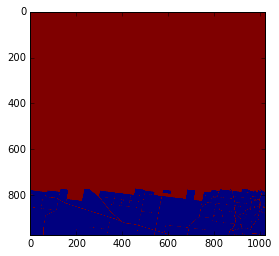

In [67]:
plt.imshow(array)
plt.show()

In [11]:
np.unique(array)

array([0, 2], dtype=uint8)

In [12]:
layerDefinition = layer.GetLayerDefn()
layerDefinition.GetFieldCount()

19

In [13]:
[layerDefinition.GetFieldDefn(i).GetName() for i in range(layerDefinition.GetFieldCount())]

['PARCEL_PFI',
 'PARCEL_SPI',
 'PC_LGAC',
 'LGA',
 'CMA',
 'PR_PROPNUM',
 'PROP_PFI',
 'LU_CODE',
 'LU_DESC',
 'LU_1',
 'LU_2',
 'LU_3',
 'LC_CODE_14',
 'LC_CODE_15',
 'LC_DESC_14',
 'LC_DESC_15',
 'HECTARES',
 'TENURE',
 'IRR_STATUS']

In [14]:
# find all unique LC_CODE_14 values
layer[0].items()['LC_DESC_14']

'Pasture and grassland'

In [15]:
unique_classes = np.unique([feature.items()['LC_DESC_14'] for feature in layer])

In [16]:
print(unique_classes)

['Brassicas' 'Cereals' 'Hardwood plantation' 'Native woody cover'
 'Pasture and grassland' 'Softwood Plantation' 'Unknown']


In [17]:
# set filter
layer.SetAttributeFilter("LC_DESC_14 = 'Brassicas'")
layer.GetFeatureCount()

40

In [18]:
# unset filter
layer.SetAttributeFilter(None)
layer.GetFeatureCount()

3634

In [19]:
unique_classes_dict = {i: unique_classes[i] for i in range(len(unique_classes))}
unique_classes_dict

{0: 'Brassicas',
 1: 'Cereals',
 2: 'Hardwood plantation',
 3: 'Native woody cover',
 4: 'Pasture and grassland',
 5: 'Softwood Plantation',
 6: 'Unknown'}

In [20]:
for i, cls in unique_classes_dict.items():
    layer.SetAttributeFilter("LC_DESC_14 = '%s'" % cls)
    print("%s: %d" % (cls, layer.GetFeatureCount()))
layer.SetAttributeFilter(None)

Brassicas: 40
Cereals: 416
Hardwood plantation: 56
Native woody cover: 51
Pasture and grassland: 392
Softwood Plantation: 6
Unknown: 2684


0

In [69]:
# draw regions class by class
NoData_value = -10
layer.SetAttributeFilter(None)
x_min, x_max, y_min, y_max = filter_poly.GetEnvelope()
x_res = 1022
y_res = 973
pixel_size = (x_max - x_min) / x_res

target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
# target_ds.SetGeoTransform((x_max, pixel_size, 0, y_min, 0, -pixel_size))
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)

# Rasterize

# layer.SetAttributeFilter("LC_DESC_14 = '%s'" % unique_classes_dict[6])
# gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[i])

for i, cls in unique_classes_dict.items():
    layer.SetAttributeFilter("LC_DESC_14 = '%s'" % cls)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[i])
layer.SetAttributeFilter(None)

0

In [70]:
array = band.ReadAsArray()

In [71]:
np.unique(array)

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

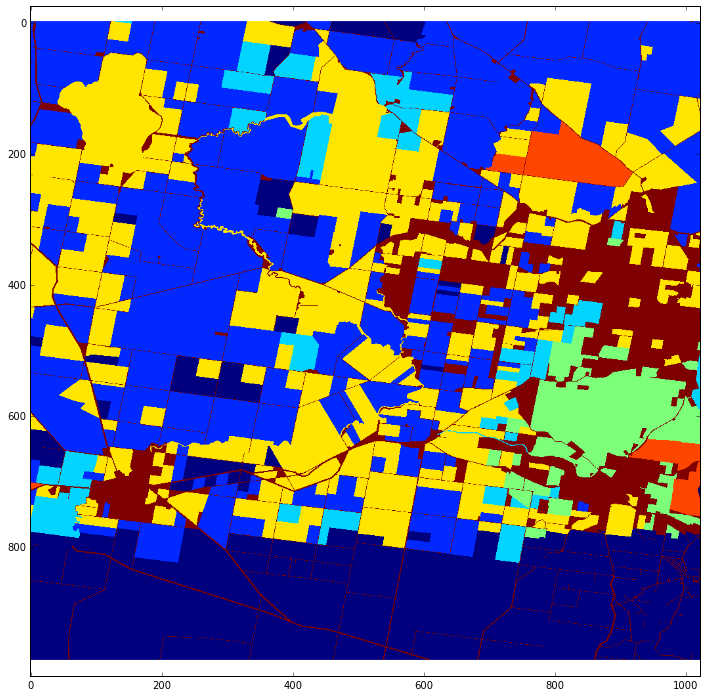

In [72]:
plt.figure(figsize=(12, 12))
plt.axis('equal')
plt.imshow(array)
plt.show()

In [68]:
filter_poly.GetEnvelope()

(143.32180000642074, 143.5968081449812, -37.70330610816869, -37.49575155973978)